In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import bayes_mvs as bayesest
import os #Lib for get the operative system sintaxis
from sklearn import linear_model#Machine learning package for a smart plot fit
from scipy import stats
from decimal import Decimal
import math
import seaborn as sns

In [2]:
def indexes(y):#peak detection algorithm
    dy = np.diff(y)
    #plt.plot(ady)
    ind = []
    for i in range(len(dy)-1):
        if len(ind) > 0:
            if abs(dy[i-1])<0.25*y[i] and dy[i]<-0.3*y[i] and abs(dy[i+1])<0.25*y[i]:
                ind.append(i)
        elif len(ind) == 0:
            if  dy[i]<-0.3*y[i]:
                ind.append(i)
    return ind  

In [3]:
lane=1
timebetframes=15/60
medium='m3'
peakdist=2
fitthresh=0.8 #threshold in the fit score to consider the cell cicle
pixelsize=0.11 #pixelsize (mum/px)

In [4]:
data=pd.read_csv("./RawDataAdder.csv")
replica=data['Replica'].unique()

In [5]:
%matplotlib inline
data=pd.read_csv("./RawDataAdder.csv")
replica=data['Replica'].unique()

    
plt.rcParams.update({'figure.max_open_warning': 0})
#data=dataraw[dataraw.lane_num==lane]

DSMdata=[]#np.array([["Sb","Sd","gr","timediv","score","Replica"]])
CRMdata=[]#np.array([["Mother","time","SizeFit","Size","gr","score","Replica"]])
CRMdatasyn=[]
#td=[]
#goodsz=[]
#grsimple=[]
#gooddata=[]
filtdata=[]
repinx=1
for rep in replica:
    df=data[data.Replica==rep]
    moms=df['mom'].unique()
    grs=[]
    df=df.reset_index()
    tbf=(df.loc[1].time-df.loc[0].time)*15/60
    for k in range(len(moms)):
        tempCRM=[]
        tempCRMsyn=[]
        tempv=[]
        dataM=df[df.mom==moms[k]]
        datat=dataM.sort_values(by="time")
        ln = np.array(datat.length)
        
        time = np.array(datat.time*15/60)
        
        peaksval=[]  
        fitl=[]
        fitt=[]
        peaks = indexes(ln)
        avscore=[]
        if (len(peaks)!=0):
            coor=[]
            for i in range(len(peaks)):        
                if(i>0):
                    d=float(time[peaks[i]]-time[peaks[i-1]])#division time
                    tt=peaks[i-1]+1#initial time for ransac estimation
                    tt2=peaks[i-1]-peaks[0]+1
                else:
                    d=0
                    tt=0
                peaksval.append([time[peaks[i]],ln[peaks[i]]]) 
                dt=[]#array of log(len)
                tm=[]
                results=[]
                temp=0
                while(tt<=peaks[i]):
                    dt.append(np.log(ln[tt]))
                    tm.append(temp)
                    temp=temp+tbf
                    tt=tt+1
                if(len(dt)>1):#guarantees there is enought data
                    tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                    model_ransac.fit(tm,dt)#smart fit
                    a=model_ransac.estimator_.coef_#growth rate
                    l0=np.exp(model_ransac.estimator_.intercept_)
                    avscore.append(model_ransac.score(tm, dt))
                    if(i>0):
                        tt=peaks[i-1]+1#temporaltime
                        tt2=peaks[i-1]-peaks[0]+1
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tempCRMsyn.append([moms[k],time[tt2],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt+=1
                            tt2+=1
                        if(score>0.9):                        
                            tempvf=l0*np.exp((-time[peaks[i-1]+1]+time[peaks[i]]+(tbf/2))*a[0])
                            tempv0=l0*np.exp(-tbf*a[0]/2)
                            if tempvf>tempv0:                            
                                avt=(time[peaks[i-1]]+time[peaks[i]])/2
                                timediv=-time[peaks[i-1]]+time[peaks[i]]
                                tempv.append([tempv0,tempvf,tempvf-tempv0,a[0],avt,timediv,score,repinx])
                                tt=peaks[i-1]+1#temporaltime
                                if(model_ransac.score(tm,dt)>fitthresh):
                                    coor.append([time[peaks[i]],pixelsize*ln[peaks[i]],model_ransac.score(tm,dt)])
                        tt=peaks[i-1]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                            
                                
                    else:
                        tt=0
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[0]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1 
            peaksval=np.array(peaksval)
        if len(tempv)>6:
            fitl=[]
            fitt=[]
            for gg in tempCRM:     
                if len(CRMdata)==0:
                    CRMdata=[gg]
                else:
                    CRMdata=np.concatenate((CRMdata,[gg]),axis=0)
                
                fitl.append(gg[2])
                fitt.append(gg[1])
            for gg in tempCRMsyn:     
                if len(CRMdatasyn)==0:
                    CRMdatasyn=[gg]
                else:
                    CRMdatasyn=np.concatenate((CRMdatasyn,[gg]),axis=0)
            for pp in tempv:
                if len(DSMdata)==0:
                    DSMdata=[pp]
                else:
                    DSMdata=np.concatenate((DSMdata,[pp]),axis=0)
    print(repinx)
    repinx+=1

1
2
3


In [6]:
df=pd.DataFrame(DSMdata,columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
dataf=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
Rep=df.Replica.unique()
for r in Rep:
    df2=df[df.Replica==r]
    sz=np.mean(df2.Sb)
    dftemp=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
    dftemp['Sb']=df2.Sb/sz
    dftemp['Sd']=df2.Sd/sz
    dftemp['Added']=df2.Sb/sz
    dftemp['gr']=df2.gr
    dftemp['timediv']=df2.timediv
    dftemp['timecycle']=df2.timecycle*np.mean(df2.gr)/np.log(2)
    dftemp['score']=df2.score
    dftemp['Replica']=df2.Replica
    dataf=pd.concat([dataf,dftemp])
    
df=dataf
df=df[np.abs(scipy.stats.zscore(df.Sd))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Sb))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Added))<3.5]
df=df[np.abs(scipy.stats.zscore(df.gr))<3.5]
df=df[np.abs(scipy.stats.zscore(df.timecycle))<4]
df=df[df.score>0.8]


df.to_csv("./DSMdataAdder.csv",index=False)

#df.to_csv("./DSMdataAdder.csv",index=False)
df=pd.DataFrame(CRMdata,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[18,19.2]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataAdder.csv",index=False)
df=pd.DataFrame(CRMdatasyn,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[18,19.2]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataAddersyn.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [7]:
data1=pd.read_csv("./CRMdataAdder.csv")

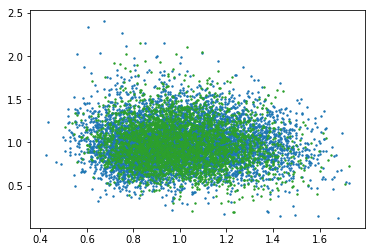

In [8]:
data1=pd.read_csv("./DSMdataAdder.csv")
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    plt.scatter(df.Sb,df.Sd-df.Sb,s=2)

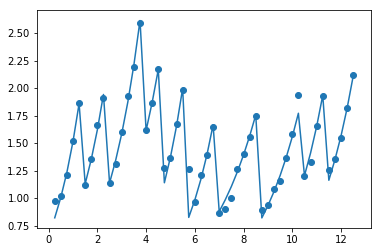

In [9]:
data=pd.read_csv("./CRMdataAddersyn.csv")
plt.plot(data[data.Mother==0].time,data[data.Mother==0].SizeFit)
plt.scatter(data[data.Mother==0].time,data[data.Mother==0].Size)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


(1, 1.8)

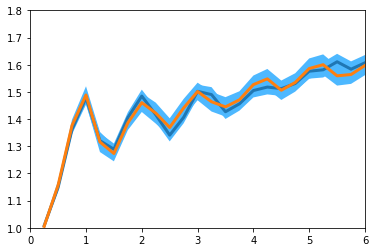

In [15]:
data=pd.read_csv("./CRMdataAddersyn.csv")
i=0
for r in [1,3]:
    df=data[data.Replica==r]
    tarray=np.sort(df.time.unique())
    meansz=[]
    errorsz=[]
    meancv2sz=[]
    errorcv2sz=[]
    tt=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(dft)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz.append(mean_cntr[0])
            errorsz.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz.append(errv)
            tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tt,meansz,lw=3)
    plt.fill_between(tt, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1
plt.xlim(0,6)
plt.ylim(1,1.8)

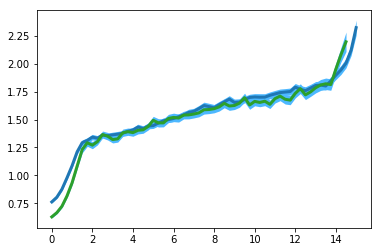

In [16]:
data=pd.read_csv("./CRMdataAdder.csv")

for r in [1,2,3]:
    df=data[data.Replica==r]
    tarray=np.sort(df.time.unique())
    meansz=[]
    errorsz=[]
    meancv2sz=[]
    errorcv2sz=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz.append(mean_cntr[0])
            errorsz.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz.append(errv)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray,meansz,lw=3)
    plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
#plt.ylim([0,0.7])

(0.05, 0.14)

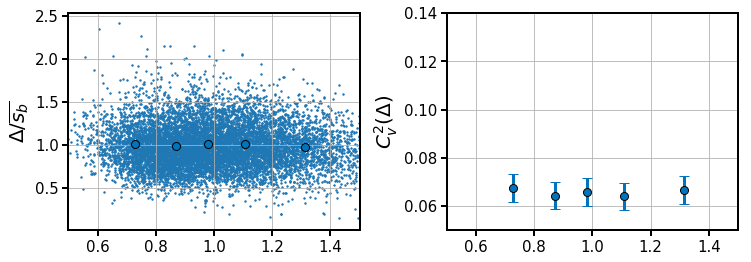

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
data2=pd.read_csv("./DSMdataAdder.csv")
ax[0].scatter(data2.Sb/np.mean(data2.Sb),(data2.Sd-data2.Sb)/np.mean(data2.Sb),s=2)

quantnumber=5
pvadd2=data2
CV2d=[]
delt=[]
sb=[]
    
errcv2d=[]
errdelt=[]
errsb=[]
for i in range(quantnumber):
    lperv0=np.percentile(pvadd2.Sb,i*100/quantnumber)
    hperv0=np.percentile(pvadd2.Sb,(i+1)*100/quantnumber)
    quanta1=pvadd2[pvadd2.Sb>lperv0]
    quanta2=quanta1[quanta1.Sb<hperv0]     
    mean_cntr, var_cntr, std_cntr = bayesest((quanta2.Sd-quanta2.Sb)/np.mean(pvadd2.Sd-pvadd2.Sb),alpha=0.95)
    meanv0_cntr, varv0_cntr, stdv0_cntr = bayesest(quanta2.Sb/np.mean(pvadd2.Sb),alpha=0.95)
    CV2d.append(var_cntr[0]/mean_cntr[0]**2)
    delt.append(mean_cntr[0])
    sb.append(meanv0_cntr[0])
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2d.append(errv)
    errdelt.append(mean_cntr[1][1]-mean_cntr[0])
    errsb.append(meanv0_cntr[1][1]-meanv0_cntr[0])
ax[0].errorbar(np.array(sb),np.array(delt),xerr=errsb,yerr=errdelt, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].errorbar(np.array(sb),CV2d,xerr=errsb,yerr=errcv2d, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].set_ylim([0,0.3])


#lamb=1.5
#nsteps=8
#s0=(1/nsteps)**(1/lamb)
#xx = np.arange(0,3,0.01)
#def rel(x):
#    return lamb**(1/lamb)*np.exp((x)**lamb/lamb)*scipy.special.gamma(1+1/lamb)*scipy.special.gammaincc(1+1/lamb,(x)**lamb/lamb)-2*x
#s0r=scipy.optimize.bisect(rel,0,100)
#avg=s0*np.exp((xx/s0)**lamb/lamb)*lamb**(1/lamb)*scipy.special.gamma(1+1/lamb)*scipy.special.gammaincc(1+1/lamb, (xx/s0)**lamb/lamb)
#avg2=s0*s0*lamb**(2/lamb)*np.exp((xx/s0)**lamb/lamb)*scipy.special.gamma(1+2/lamb)*scipy.special.gammaincc(1+2/lamb, (xx/s0)**lamb/lamb)

#ax[0].plot(sbarray/1.55,(np.array(sizedivarr05)-np.array(sbarray))/1.55,lw=2,label='$\gamma_p=\mu$',c='#E00000',linestyle='dotted')
#ax[1].plot(sbarray/1.55,np.array(CV2arr05),lw=2,c='#E00000',linestyle='dotted')
#ax[0].plot(xx/(s0*s0r),((avg-xx)/s0)/(s0r),lw=3,label='$\lambda=%.1f$' %lamb,c='#2DB102',linestyle='dashed')    
#ax[1].plot(xx/(s0*s0r),(avg2-avg**2)/(nsteps*(avg-xx)**2),lw=3,c='#2DB102',linestyle='dashed')
#ax[1].plot(sbarray2/1.25,np.array(CV2arr01a),lw=2,c='k',label='$s_0=1,H=2.5,M=9$')
#ax[0].plot(sbarray2/1.25,(np.array(sizedivarr01a)-np.array(sbarray2))/1.25,lw=3,c='k')
#ax[1].legend(fontsize=15)

ax[0].set_xlim(0.5,1.5)
ax[1].set_xlim(0.5,1.5)
for i in [0,1]:
    ax[i].grid()
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].tick_params(axis='both', width=2,length=6)
        #ax[i].legend(fontsize=15)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel(r'$\Delta/\overline{s_b}$',size=20)
ax[1].set_ylabel(r'$C^2_v(\Delta)$',size=20)
ax[1].set_ylim(0.05,0.14)

(0, 0.7)

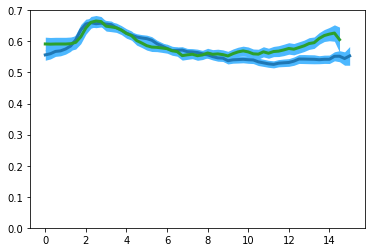

In [18]:
%matplotlib inline
data=pd.read_csv("./CRMdataAdder.csv")
data=data[data.score>0.9]
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    tarray=np.sort(df.time.unique())
    meangr=[]
    errorgr=[]
    meancv2gr=[]
    errorcv2gr=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.gr,alpha=0.95)
            meangr.append(mean_cntr[0])
            errorgr.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2gr.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2gr.append(errv)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray,meangr,lw=3)
    plt.fill_between(tarray, np.array(meangr)+np.array(errorgr), np.array(meangr)-np.array(errorgr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
plt.ylim([0,0.7])

In [19]:
mean_size = 1 # femto liter
doubling_time = 18 #min
tmax = 180 #min
sample_time = 2 #min
div_steps = 25
ncells = 5000 
gr = np.log(2)/doubling_time 

In [20]:
import sys
from PyEcoLib.simulator import Simulator

CV2sz = 0.02
CV2div = 0.01
CV2gr = 0.015
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM3.csv")
#print('It took', np.int(time.time()-start), 'seconds.')

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [21]:
data=pd.read_csv("./dataCRM3.csv")
taumax=55
tauarr3=range(taumax)
tarr=data.time.tolist()
corarr3=[]
for tau in tauarr3:
    xx=[]
    yy=[]
    for i in range(20):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    corarr3.append(np.corrcoef(xx,yy)[0][1])

In [22]:
data=pd.read_csv("./CRMdataAddersyn.csv")
data=data[data.Replica==1]
taumax=25
tauarr2=range(taumax)
tarr=data.time.tolist()
corarr2=[]
for tau in tauarr2:
    print(tau)
    xx=[]
    yy=[]
    for i in np.arange(0,20,2):
        
        df=data[data.time==tarr[i]]
        datamom1=df.Mother.unique()
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        datamom2=df2.Mother.unique()
        allmom=[]
        A=[]
        B=[]
        for m in datamom1:
            if m in datamom2:
                A.append(df[df.Mother==m].Size.tolist()[0])
                B.append(df2[df2.Mother==m].Size.tolist()[0])
        del df2['time']

        
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    corarr2.append(np.corrcoef(xx,yy)[0][1])
#inspace(0,3.15,len(corarr2)),corarr2,label="Experiment",c='red')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [23]:
len(corarr2)

25

(0, 5)

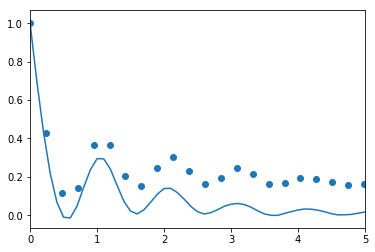

In [24]:
plt.plot(np.array(tauarr3)/10,corarr3)
plt.scatter(np.array(tauarr2)*0.25*0.95,corarr2)
plt.xlim(0,5)

In [25]:
data1=pd.read_csv("./CRMdataAddersyn.csv")

(1, 1.8)

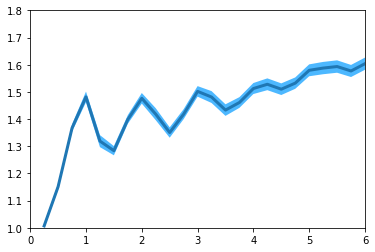

In [28]:
data=pd.read_csv("./CRMdataAddersyn.csv")
i=0
for r in [1]:
    df=data
    tarray3=np.sort(df.time.unique())
    meansz3=[]
    errorsz3=[]
    meancv2sz3=[]
    errorcv2sz3=[]
    tt=[]
    for t in tarray3:
        dft=df[df.time==t]
        if (len(dft)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz3.append(mean_cntr[0])
            errorsz3.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz3.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz3.append(errv)
            tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tt,meansz3,lw=3)
    plt.fill_between(tt, np.array(meansz3)+np.array(errorsz3), np.array(meansz3)-np.array(errorsz3),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1
plt.xlim(0,6)
plt.ylim(1,1.8)

In [29]:
data1=pd.read_csv("./dataCRM3.csv")
timearray3=data1.time.unique()

mnszarray3=[]
cvszarray3=[]
errcv2sz3=[]
errmnsz3=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray3.append(np.mean(szs))
    errmnsz3.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray3.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz3.append(errv)

1155
1192
1193
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1184
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1194
1193
1193
1182
1191
1186
1183
1177
1172
1164
1154
1143
1125
1114
1091
1059
1021
986
939
866
779
653
527
394
281
176
101
57
28
13
9
4
1


(0.9, 1.7)

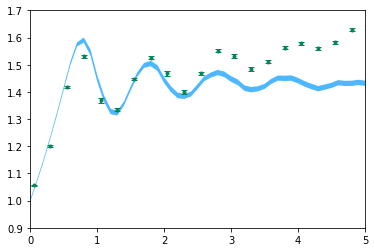

In [32]:
data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    print(len(dft))
    if (len(dft)>1):
#        timecorrect.append(t)
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tt)-0.2),(np.array(meansz)+0.05),yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.fill_between(timearray3/18, np.array(mnszarray3)+np.array(errmnsz3), np.array(mnszarray3)-np.array(errmnsz3),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
plt.xlim(0,5)
plt.ylim(0.9,1.7)

(0, 0.15)

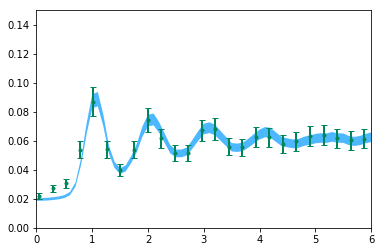

In [34]:
data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>1):
#        timecorrect.append(t)
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tt)-0.2)/1.03,meancv2sz,yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.fill_between(np.array(timearray3)/18,np.array(cvszarray3)-np.array(errcv2sz3),np.array(cvszarray3)
                   +np.array(errcv2sz3),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
plt.xlim(0,6)
plt.ylim(0,0.15)

In [38]:
%matplotlib inline
data=pd.read_csv("./rawdata.csv")
replica=data['Replica'].unique()

    
plt.rcParams.update({'figure.max_open_warning': 0})
#data=dataraw[dataraw.lane_num==lane]

DSMdata=[]#np.array([["Sb","Sd","gr","timediv","score","Replica"]])
CRMdata=[]#np.array([["Mother","time","SizeFit","Size","gr","score","Replica"]])
CRMdatasyn=[]
#td=[]
#goodsz=[]
#grsimple=[]
#gooddata=[]
filtdata=[]
repinx=1
for rep in replica:
    df=data[data.Replica==rep]
    moms=df['mom'].unique()
    grs=[]
    df=df.reset_index()
    tbf=(df.loc[1].time-df.loc[0].time)*15/60
    for k in range(len(moms)):
        tempCRM=[]
        tempCRMsyn=[]
        tempv=[]
        dataM=df[df.mom==moms[k]]
        datat=dataM.sort_values(by="time")
        ln = np.array(datat.length)
        
        time = np.array(datat.time*15/60)
        
        peaksval=[]  
        fitl=[]
        fitt=[]
        peaks = indexes(ln)
        avscore=[]
        if (len(peaks)!=0):
            coor=[]
            for i in range(len(peaks)):        
                if(i>0):
                    d=float(time[peaks[i]]-time[peaks[i-1]])#division time
                    tt=peaks[i-1]+1#initial time for ransac estimation
                    tt2=peaks[i-1]-peaks[0]+1
                else:
                    d=0
                    tt=0
                peaksval.append([time[peaks[i]],ln[peaks[i]]]) 
                dt=[]#array of log(len)
                tm=[]
                results=[]
                temp=0
                while(tt<=peaks[i]):
                    dt.append(np.log(ln[tt]))
                    tm.append(temp)
                    temp=temp+tbf
                    tt=tt+1
                if(len(dt)>1):#guarantees there is enought data
                    tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                    model_ransac.fit(tm,dt)#smart fit
                    a=model_ransac.estimator_.coef_#growth rate
                    l0=np.exp(model_ransac.estimator_.intercept_)
                    avscore.append(model_ransac.score(tm, dt))
                    if(i>0):
                        tt=peaks[i-1]+1#temporaltime
                        tt2=peaks[i-1]-peaks[0]+1
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tempCRMsyn.append([moms[k],time[tt2],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt+=1
                            tt2+=1
                        if(score>0.8):                        
                            tempvf=l0*np.exp((-time[peaks[i-1]+1]+time[peaks[i]]+(tbf/2))*a[0])
                            tempv0=l0*np.exp(-tbf*a[0]/2)
                            if tempvf>tempv0:                            
                                avt=(time[peaks[i-1]]+time[peaks[i]])/2
                                timediv=-time[peaks[i-1]]+time[peaks[i]]
                                tempv.append([tempv0,tempvf,tempvf-tempv0,a[0],avt,timediv,score,repinx])
                                tt=peaks[i-1]+1#temporaltime
                                if(model_ransac.score(tm,dt)>fitthresh):
                                    coor.append([time[peaks[i]],pixelsize*ln[peaks[i]],model_ransac.score(tm,dt)])
                        tt=peaks[i-1]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                            
                                
                    else:
                        tt=0
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[0]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1 
            peaksval=np.array(peaksval)
        if len(tempv)>4:
            fitl=[]
            fitt=[]
            for gg in tempCRM:     
                if len(CRMdata)==0:
                    CRMdata=[gg]
                else:
                    CRMdata=np.concatenate((CRMdata,[gg]),axis=0)
                
                fitl.append(gg[2])
                fitt.append(gg[1])
            for gg in tempCRMsyn:     
                if len(CRMdatasyn)==0:
                    CRMdatasyn=[gg]
                else:
                    CRMdatasyn=np.concatenate((CRMdatasyn,[gg]),axis=0)
            for pp in tempv:
                if len(DSMdata)==0:
                    DSMdata=[pp]
                else:
                    DSMdata=np.concatenate((DSMdata,[pp]),axis=0)
    print(repinx)
    repinx+=1

1
2
3


In [39]:
df=pd.DataFrame(DSMdata,columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
dataf=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
Rep=df.Replica.unique()
for r in Rep:
    df2=df[df.Replica==r]
    sz=np.mean(df2.Sb)
    dftemp=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","timecycle","score","Replica"])
    dftemp['Sb']=df2.Sb/sz
    dftemp['Sd']=df2.Sd/sz
    dftemp['Added']=df2.Sb/sz
    dftemp['gr']=df2.gr
    dftemp['timediv']=df2.timediv
    dftemp['timecycle']=df2.timecycle*np.mean(df2.gr)/np.log(2)
    dftemp['score']=df2.score
    dftemp['Replica']=df2.Replica
    dataf=pd.concat([dataf,dftemp])
    #df.loc[df.Replica==r,'Sb':]*=1/sz
    #df.loc[df.Replica==r,'Sb':]*=1/np.mean(df2.Sb)
    #df.loc[df.Replica==r,'Sd':]*=1/np.mean(df2.Sb)
    #df.loc[df.Replica==r,'Added':]*=1/np.mean(df2.Sb)
    
df=dataf
df=df[np.abs(scipy.stats.zscore(df.Sd))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Sb))<3.5]
df=df[np.abs(scipy.stats.zscore(df.Added))<3.5]
df=df[np.abs(scipy.stats.zscore(df.gr))<3.5]
df=df[np.abs(scipy.stats.zscore(df.timecycle))<4]
df=df[df.score>0.8]


df.to_csv("./DSMdataSizer.csv",index=False)

#df.to_csv("./DSMdataAdder.csv",index=False)
df=pd.DataFrame(CRMdata,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[19,17.3,18]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataSizer.csv",index=False)
df=pd.DataFrame(CRMdatasyn,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
szs=[19,17.3,18]
dataf=pd.DataFrame(columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
Rep=df.Replica.unique()
i=0
for r in Rep:
    df2=df[df.Replica==r]
    sz=szs[i]
    dftemp=df2
    dftemp['SizeFit']=dftemp.SizeFit/sz
    dftemp['Size']=dftemp.Size/sz
    i+=1
    dataf=pd.concat([dataf,dftemp])
df=dataf
df.to_csv("./CRMdataSizersyn.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

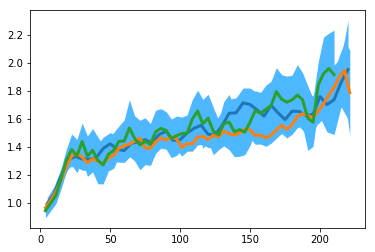

In [40]:
data=pd.read_csv("./CRMdataSizersyn.csv")
#meanarr=[19,17,18]
#i=0
for r in [1,2,3]:
    df=data[data.Replica==r]
    tarray=np.sort(df.time.unique())
    #print(tarray)
    meansz4=[]
    errorsz4=[]
    meancv2sz4=[]
    errorcv2sz4=[]
    tarray4=[]
    for t in tarray:
        dft=df[df.time==t]
        #print(dft)
        if (len(dft)>2):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz4.append(mean_cntr[0])
            errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz4.append(errv)
            tarray4.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray4,meansz4,lw=3)
    plt.fill_between(tarray4, np.array(meansz4)+np.array(errorsz4), np.array(meansz4)-np.array(errorsz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1
#plt.xlim(0,6)
#plt.ylim(1,1.8)

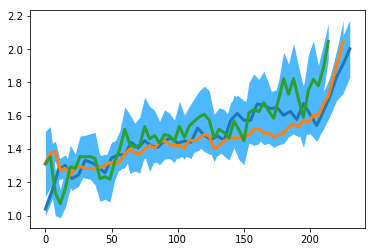

In [41]:
data=pd.read_csv("./CRMdataSizer.csv")
meanarr=[18,18,19.2]
i=0
for r in [1,2,3]:
    df=data[data.Replica==r]
    tarray=np.sort(df.time.unique())
    #print(tarray)
    meansz4=[]
    errorsz4=[]
    meancv2sz4=[]
    errorcv2sz4=[]
    tarray4=[]
    for t in tarray:
        dft=df[df.time==t]
        #print(dft)
        if (len(dft)>2):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
            meansz4.append(mean_cntr[0])
            errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2sz4.append(errv)
            tarray4.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray4,meansz4,lw=3)
    plt.fill_between(tarray4, np.array(meansz4)+np.array(errorsz4), np.array(meansz4)-np.array(errorsz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
    i+=1
#plt.xlim(0,6)
#plt.ylim(1,1.8)

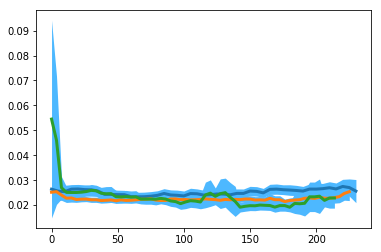

In [42]:
%matplotlib inline
data=pd.read_csv("./CRMdataSizer.csv")
data=data[data.score>0.8]
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    tarray=np.sort(df.time.unique())
    meangr=[]
    errorgr=[]
    meancv2gr=[]
    errorcv2gr=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.gr,alpha=0.95)
            meangr.append(mean_cntr[0])
            errorgr.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2gr.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2gr.append(errv)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    plt.plot(tarray,meangr,lw=3)
    plt.fill_between(tarray, np.array(meangr)+np.array(errorgr), np.array(meangr)-np.array(errorgr),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)
#plt.ylim([0,0.7])

In [43]:
def errorcor(x,y):
    meanar=[]
    varar=[]
    for m in range(100):
        bstx=[]
        bsty=[]
        for m in range(len(x)):
            r=np.random.randint(len(x))
            bstx.append(x[r])
            bstx.append(y[r])
        meanar.append(np.corrcoef(xx,yy)[0][1])


    confmn=(np.abs(np.percentile(meanar,5)-np.mean(meanar))+np.abs(np.percentile(meanar,95)-np.mean(meanar)))/2
    return [np.mean(meanar),confmn]

In [44]:
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
taumax=50
tauarr5=range(taumax)
tarr=data.time.tolist()
corarr5=[]
errorcorr5=[]
for tau in tauarr5:
    print(tau)
    xx=[]
    yy=[]
    for i in np.arange(0,20,2):
        
        df=data[data.time==tarr[i]]
        datamom1=df.Mother.unique()
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        datamom2=df2.Mother.unique()
        allmom=[]
        A=[]
        B=[]
        for m in datamom1:
            if m in datamom2:
                A.append(df[df.Mother==m].Size.tolist()[0])
                B.append(df2[df2.Mother==m].Size.tolist()[0])
        del df2['time']

        
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr5.append(errorcor(xx,yy)[0])
    errorcorr5.append(errorcor(xx,yy)[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [45]:
import sys
from PyEcoLib.simulator import Simulator

div_steps=10
CV2sz = 0.04
CV2div = 0.01
CV2gr = 0.017
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0,lamb=1.5)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM4.csv")

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [46]:
data=pd.read_csv("./dataCRM4.csv")
taumax=60
tauarr4=range(taumax)
tarr=data.time.tolist()
corarr4=[]
for tau in tauarr4:
    xx=[]
    yy=[]
    for i in range(30):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        print
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr4.append(np.corrcoef(xx,yy)[0][1])

(0, 4)

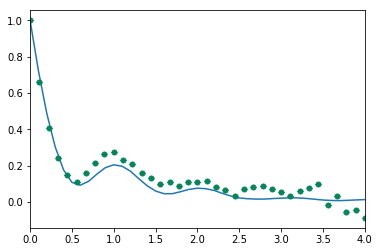

In [47]:
plt.plot(np.array(tauarr4)/10,corarr4)
plt.errorbar(np.array(tauarr5)/9,corarr5,yerr=errorcorr5,
                               color='#008658',capsize=3,fmt='o',markersize='5',elinewidth=2)

plt.xlim(0,4)

In [48]:
data1=pd.read_csv("./dataCRM4.csv")
timearray4=data1.time.unique()

mnszarray4=[]
cvszarray4=[]
errcv2sz4=[]
errmnsz4=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray4.append(np.mean(szs))
    errmnsz4.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray4.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz4.append(errv)

(0, 8)

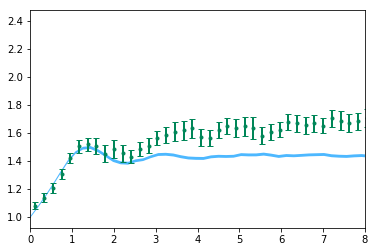

In [49]:
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
        #print(dft)
    if (len(dft)>2):
#        timecorrect.append(t)
        #print(len(dft))
        mean_cntr, var_cntr, std_cntr = bayesest(1.12*dft.Size,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tarray4)-1.5)/(18),meansz4,yerr=errorsz4,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.fill_between(np.array(timearray4)/10,np.array(mnszarray4)-np.array(errmnsz4),np.array(mnszarray4)
                 +np.array(errmnsz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
plt.xlim(0,8)
#plt.ylim(0,0.15)

190
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
195
194
193
192
192
188
185
182
179
172
169
163
156
146
138
118
105
92
77
59
48
29
15
4


(0, 0.15)

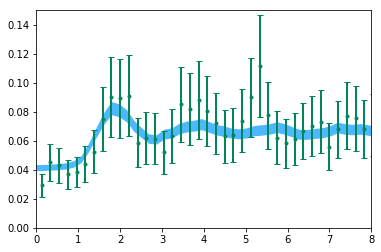

In [50]:
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
        #print(dft)
    if (len(dft)>2):
#        timecorrect.append(t)
        print(len(dft))
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tarray4)-1.5)/18,meancv2sz4,yerr=errorcv2sz4,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.fill_between(np.array(timearray4)/10,np.array(cvszarray4)-np.array(errcv2sz4),np.array(cvszarray4)
                   +np.array(errcv2sz4),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',linewidth=0)
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
plt.xlim(0,8)
plt.ylim(0,0.15)

In [51]:
CV2sz = 0.01
CV2div = 0
CV2gr = 0

div_steps=15
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM6.csv")
sim.szdynFSP(tmax = tmax, nameFSP = "./dataFSP6.csv",CV2sz=CV2sz) 
#print('It took', np.int(time.time()-start), 'seconds.')

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
6%
16%
26%
36%
46%
56%
66%
76%
86%
96%


In [52]:
data1=pd.read_csv("./dataCRM6.csv")
timearray6=data1.time.unique()

mnszarray6=[]
cvszarray6=[]
errcv2sz6=[]
errmnsz6=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray6.append(np.mean(szs))
    errmnsz6.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray6.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz6.append(errv)

In [53]:
data=pd.read_csv("./dataCRM6.csv")
taumax=60
tauarr6=range(taumax)
tarr=data.time.tolist()
corarr6=[]
for tau in tauarr6:
    xx=[]
    yy=[]
    for i in range(30):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        print
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr6.append(np.corrcoef(xx,yy)[0][1])

In [54]:
CV2sz = 0.01
CV2div = 0.01
CV2gr = 0.02

div_steps=15
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM7.csv")
#sim.szdynFSP(tmax = tmax, nameFSP = "./dataFSP7.csv",CV2sz=CV2sz) 
#print('It took', np.int(time.time()-start), 'seconds.')

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [55]:
data1=pd.read_csv("./dataCRM7.csv")
timearray7=data1.time.unique()

mnszarray7=[]
cvszarray7=[]
errcv2sz7=[]
errmnsz7=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray7.append(np.mean(szs))
    errmnsz7.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray7.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz7.append(errv)

In [56]:
data=pd.read_csv("./dataCRM7.csv")
taumax=60
tauarr7=range(taumax)
tarr=data.time.tolist()
corarr7=[]
for tau in tauarr7:
    xx=[]
    yy=[]
    for i in range(30):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        print
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr7.append(np.corrcoef(xx,yy)[0][1])

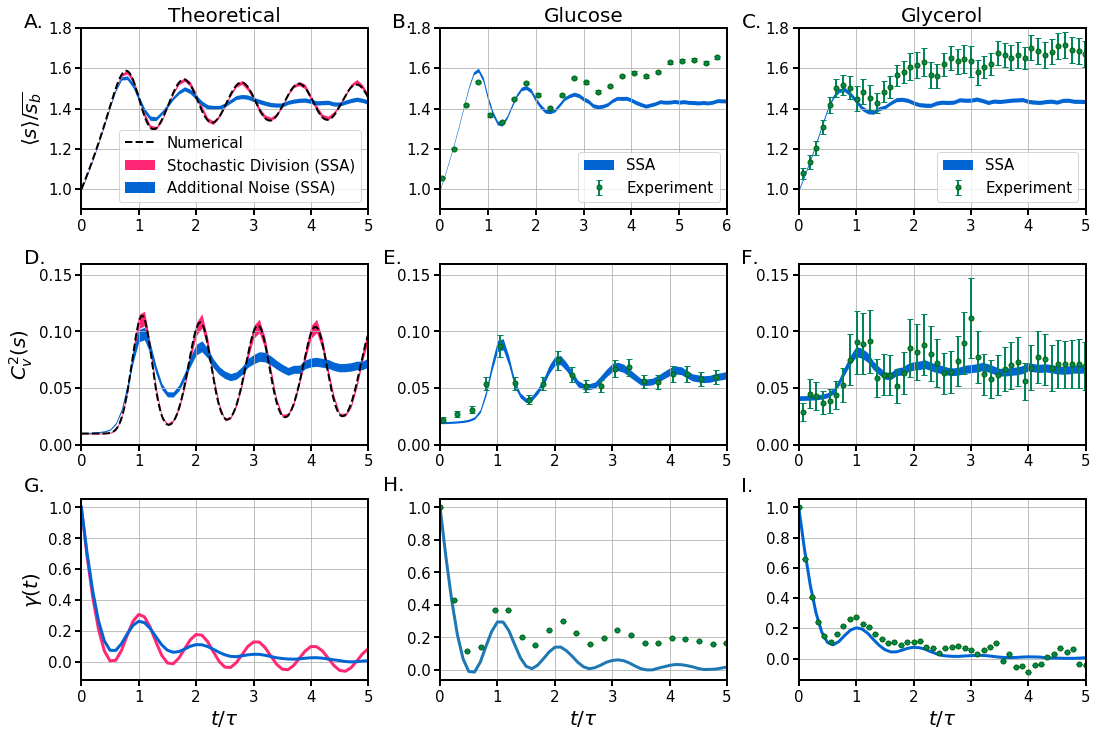

In [59]:
fig, ax = plt.subplots(3,3, figsize=(18,12))

ax[0,0].fill_between(timearray6/18, np.array(mnszarray6)+np.array(errmnsz6), np.array(mnszarray6)
                     -np.array(errmnsz6),alpha=1, edgecolor='#FF2776', facecolor='#FF2776',
    linewidth=0,label="Stochastic Division (SSA)")    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(0.9,1.8)

ax[1,0].fill_between(np.array(timearray6)/18,np.array(cvszarray6)-np.array(errcv2sz6),np.array(cvszarray6)
                   +np.array(errcv2sz6),alpha=1, edgecolor='#FF2776', facecolor='#FF2776',linewidth=0)
 
data=pd.read_csv("./dataFSP6.csv")
ax[0,0].plot(data.time/doubling_time,data.Meansize,ls='--',c='k',label="Numerical",lw=2)
ax[1,0].plot(data.time/doubling_time,data.VarSize/data.Meansize**2,ls='--',c='k',lw=2)

ax[1,0].set_xlim(0,5)
#ax[0,0].set_ylim(0.9,1.8)

ax[2,0].plot(np.array(tauarr6)/10,corarr6,lw=3,c='#FF2776')
ax[1,0].set_ylim(0.0,0.14)

#____________________________________________________
ax[0,0].fill_between(timearray6/18, np.array(mnszarray7)+np.array(errmnsz7), np.array(mnszarray7)
                     -np.array(errmnsz7),alpha=1, edgecolor='#0065D3', facecolor='#0065D3',
    linewidth=0,label="Additional Noise (SSA)")    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(0.9,1.8)

ax[1,0].fill_between(np.array(timearray7)/18,np.array(cvszarray7)-np.array(errcv2sz7),np.array(cvszarray7)
                   +np.array(errcv2sz7),alpha=1, edgecolor='#0065D3', facecolor='#0065D3',linewidth=0)
 

ax[1,0].set_xlim(0,5)
#ax[0,0].set_ylim(0.9,1.8)

ax[2,0].plot(np.array(tauarr7)/10,corarr7,c='#0065D3',lw=3)
ax[1,0].set_ylim(0.0,0.14)
#_____________________________________________________________


data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>1):
#        timecorrect.append(t)
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
ax[0,1].errorbar((np.array(tt)-0.2),(np.array(meansz)+0.05),mec='#016400',yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='5',elinewidth=2,label="Experiment")
ax[0,1].fill_between(timearray3/18, np.array(mnszarray3)+np.array(errmnsz3), np.array(mnszarray3)-np.array(errmnsz3),
                     alpha=1, edgecolor='#0065D3', facecolor='#0065D3',    linewidth=0,label="SSA")    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[0,1].set_xlim(0,6)
ax[0,1].set_ylim(0.9,1.8)
ax[1,1].set_ylim(0.0,0.14)

data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
        #print(dft)
    if (len(dft)>2):
#        timecorrect.append(t)
        #print(len(dft))
        mean_cntr, var_cntr, std_cntr = bayesest(1.12*dft.Size,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
ax[0,2].errorbar((np.array(tarray4)-1.5)/(32),meansz4,yerr=errorsz4,mec='#016400',
                               color='#008658',capsize=3,fmt='o',markersize='5',elinewidth=2,label="Experiment")
ax[0,2].fill_between(np.array(timearray4)/18,np.array(mnszarray4)-np.array(errmnsz4),np.array(mnszarray4)
                 +np.array(errmnsz4),alpha=1, edgecolor='#0065D3', facecolor='#0065D3',linewidth=0,label="SSA")
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[0,2].set_xlim(0,5)
ax[1,2].set_ylim(0.0,0.16)

data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>1):
#        timecorrect.append(t)
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
ax[1,1].errorbar((np.array(tt)-0.2),meancv2sz,yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='5',mec='#016400',elinewidth=2)
ax[1,1].fill_between(np.array(timearray3)/18,np.array(cvszarray3)-np.array(errcv2sz3),np.array(cvszarray3)
                   +np.array(errcv2sz3),alpha=1, edgecolor='#0065D3', facecolor='#0065D3',linewidth=0)
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[1,1].set_xlim(0,5)
ax[1,1].set_ylim(0.0,0.16)
ax[0,2].set_ylim(0.9,1.8)
ax[1,0].set_ylim(0.0,0.16)
data=pd.read_csv("./CRMdataSizersyn.csv")
data=data[data.Replica!=1]
df=data
tarray=np.sort(df.time.unique())
meansz4=[]
errorsz4=[]
meancv2sz4=[]
errorcv2sz4=[]
tarray4=[]
for t in tarray:
    dft=df[df.time==t]
        #print(dft)
    if (len(dft)>1):
#        timecorrect.append(t)
        #print(len(dft))
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz4.append(mean_cntr[0])
        errorsz4.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz4.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz4.append(errv)
        tarray4.append(t)        #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
ax[1,2].errorbar((np.array(tarray4)-1.5)/(32),meancv2sz4,yerr=errorcv2sz4,
                               color='#008658',capsize=3,fmt='o',markersize='5',mec='#016400',elinewidth=2)
ax[1,2].fill_between(np.array(timearray4)/18,np.array(cvszarray4)-np.array(errcv2sz4),np.array(cvszarray4)
                   +np.array(errcv2sz4),alpha=1, edgecolor='#0065D3', facecolor='#0065D3',linewidth=0)
    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
ax[1,2].set_xlim(0,5)
ax[1,2].set_ylim(0,0.16)

ax[2,1].plot(np.array(tauarr3)/10,corarr3,lw=3)
ax[2,1].errorbar(np.array(tauarr2)*0.25*0.95,corarr2,yerr=np.zeros(len(corarr2)),
                               color='#008658',capsize=3,fmt='o',markersize='5',mec='#016400',elinewidth=2)
ax[2,1].set_xlim(0,5)


ax[2,2].plot(np.array(tauarr4)/10,corarr4,lw=3,c="#0065D3")
ax[2,2].errorbar(np.array(tauarr5)/9,corarr5,yerr=errorcorr5,
                               color='#008658',capsize=3,fmt='o',markersize='5',mec='#016400',elinewidth=2)

ax[2,2].set_xlim(0,5)
ax[2,0].set_xlim(0,5)
for i in [0,1,2]:
    for j in [0,1,2]:
        ax[i,j].grid()
        ax[i,j].tick_params(axis='x', labelsize=15)
        ax[i,j].tick_params(axis='y', labelsize=15)
        for axis in ['top','bottom','left','right']:
            ax[i,j].spines[axis].set_linewidth(2)
            ax[i,j].tick_params(axis='both', width=2,length=6)
        #ax[i].legend(fontsize=15)
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.25)

ax[0,0].set_ylabel(r'$\langle s \rangle/\overline{s_b}$',size=20)
ax[1,0].set_ylabel(r'$ C_v^2(s)$',size=20)
ax[2,0].set_ylabel(r'$ \gamma(t) $',size=20)

ax[2,0].set_xlabel(r'$t/\tau$',size=20)
ax[2,1].set_xlabel(r'$t/\tau$',size=20)
ax[2,2].set_xlabel(r'$t/\tau$',size=20)

ax[0,0].set_title("Theoretical",size=20)
ax[0,1].set_title("Glucose",size=20)
ax[0,2].set_title("Glycerol",size=20)
ax[0,0].legend(fontsize=15)
ax[0,1].legend(fontsize=15)
ax[0,2].legend(fontsize=15)

ax[0,0].text(-1,1.8,"A.",fontsize=20)
ax[0,1].text(-1,1.8,"B.",fontsize=20)
ax[0,2].text(-1,1.8,"C.",fontsize=20)
ax[1,0].text(-1,0.16,"D.",fontsize=20)
ax[1,1].text(-1,0.16,"E.",fontsize=20)
ax[1,2].text(-1,0.16,"F.",fontsize=20)
ax[2,0].text(-1,1.1,"G.",fontsize=20)
ax[2,1].text(-1,1.1,"H.",fontsize=20)
ax[2,2].text(-1,1.1,"I.",fontsize=20)

plt.savefig('./OscPan.eps',bbox_inches='tight',dpi=600)
plt.savefig('./OscPan.svg',bbox_inches='tight',dpi=600)

In [60]:
data1=pd.read_csv("./CRMdataAddersyn.csv")
timearray7=data1.time.unique()

mnszarray7=[]
cvszarray7=[]
errcv2sz7=[]
errmnsz7=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray7.append(np.mean(szs))
    errmnsz7.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray7.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz7.append(errv)

(0.9, 1.7)

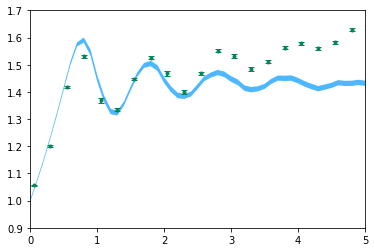

In [62]:
data=pd.read_csv("./CRMdataAddersyn.csv")
df=data
tarray=np.sort(df.time.unique())
meansz=[]
errorsz=[]
meancv2sz=[]
errorcv2sz=[]
tt=[]
for t in tarray:
    dft=df[df.time==t]
    if (len(dft)>1):
#        timecorrect.append(t)
        mean_cntr, var_cntr, std_cntr = bayesest(dft.Size,alpha=0.95)
        meansz.append(mean_cntr[0])
        errorsz.append(mean_cntr[1][1]-mean_cntr[0])
        meancv2sz.append(var_cntr[0]/mean_cntr[0]**2)
        errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
        errorcv2sz.append(errv)
        tt.append(t)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
plt.errorbar((np.array(tt)-0.2),(np.array(meansz)+0.05),yerr=errorcv2sz,
                               color='#008658',capsize=3,fmt='o',markersize='3',elinewidth=2)
plt.fill_between(timearray3/18, np.array(mnszarray3)+np.array(errmnsz3), np.array(mnszarray3)-np.array(errmnsz3),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    linewidth=0)    #        plt.scatter(tarray,meansz,lw=3)
    #plt.fill_between(tarray, np.array(meansz)+np.array(errorsz), np.array(meansz)-np.array(errorsz),alpha=1, edgecolor='#4db8ff', facecolor='#4db8ff',
    #linewidth=0)
plt.xlim(0,5)
plt.ylim(0.9,1.7)

In [64]:
CV2sz = 0.01
CV2div = 0.01
CV2gr = 0.02

div_steps=20
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM6.csv")
#sim.szdynFSP(tmax = tmax, nameFSP = "./dataFSP6.csv",CV2sz=CV2sz) 

 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [65]:
data=pd.read_csv("./dataCRM6.csv")
taumax=60
tauarr7=range(taumax)
tarr=data.time.tolist()
corarr7=[]
for tau in tauarr7:
    xx=[]
    yy=[]
    for i in range(30):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        print
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr7.append(np.corrcoef(xx,yy)[0][1])

In [66]:
data=pd.read_csv("./dataCRM6.csv")
taumax=60
tauarr7=range(taumax)
tarr=data.time.tolist()
corarrmat7=np.zeros([len(tarr)-taumax,len(tauarr7)])
l=0
m=0
for l in range(len(tarr)-taumax):
    for m in range(len(tauarr7)):
        df=data[data.time==tarr[l]]
        del df['time']
        df2=data[data.time==tarr[l+m]]
        del df2['time']
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        corarrmat7[l][m]=np.corrcoef(A,B)[0][1]
        

In [67]:
data1=pd.read_csv("./dataCRM6.csv")
timearray7=data1.time.unique()

mnszarray7=[]
cvszarray7=[]
errcv2sz7=[]
errmnsz7=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray7.append(np.mean(szs))
    errmnsz7.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray7.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz7.append(errv)

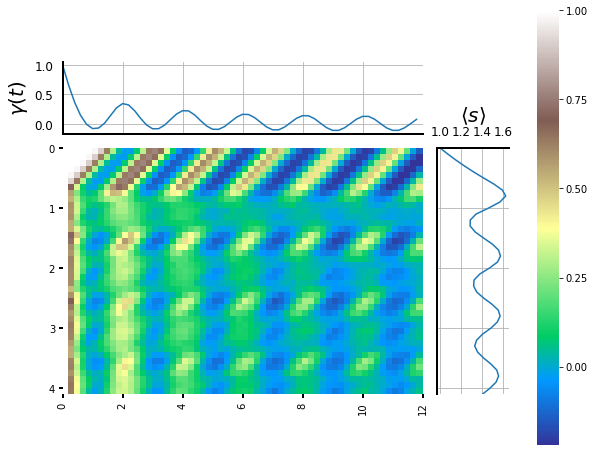

In [72]:
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig,ax=plt.subplots(figsize=(10,8))

divider = make_axes_locatable(ax)


##increased pad from 0.1 to 0.2 so that tick labels don't overlap
xhax = divider.append_axes("top", size=1, pad=0.2, sharex=ax)
yhax = divider.append_axes("right", size=1, pad=0.2, sharey=ax)

##'normalizing' x and y values to be between 0 and 1:
#xn = (x-min(x))/(max(x)-min(x))
#yn = (y-min(y))/(max(y)-min(y))

##producinc the plots

#ax.scatter(xn, yn)
xhax.plot(tauarr7,np.array(corarr7))
yhax.plot(mnszarray7,range(len(mnszarray7)))
#yhax.hist(yn,)

##turning off duplicate ticks (if needed):
plt.setp(xhax.get_xticklabels(), visible=False)
plt.setp(yhax.get_yticklabels(), visible=False)

ax.set_aspect('equal')
ax.set_xlabel("lag",fontsize=20)
ax.set_ylabel(r"$t/\tau$",fontsize=20)
xhax.set_ylabel(r"$\gamma(t)$",fontsize=20)
yhax.set_xlabel(r"$\langle s \rangle$",fontsize=20)


sns.heatmap(np.array(corarrmat7),ax=ax,cmap="terrain",annot=False)

xhax.grid()
xhax.tick_params(axis='x', labelsize=12)
xhax.tick_params(axis='y', labelsize=12)
for axis in ['bottom','left']:
    xhax.spines[axis].set_linewidth(2)
    xhax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    xhax.spines[axis].set_linewidth(0)
    xhax.tick_params(axis='both', width=0,length=6)
    
yhax.grid()
yhax.tick_params(axis='x', labelsize=12)
yhax.tick_params(axis='y', labelsize=12)
for axis in ['top','left']:
    yhax.spines[axis].set_linewidth(2)
    yhax.tick_params(axis='both', width=2,length=6)
for axis in ['bottom','right']:
    yhax.spines[axis].set_linewidth(0)
    yhax.tick_params(axis='both', width=0,length=6)
taqui=np.arange(0,70,step=10)
ax.set_xticks(np.array(taqui))

taqui=np.arange(1,1.8,step=0.2)
yhax.set_xticks(np.array(taqui))

taqui=np.arange(0,50,step=10)
ax.set_yticks(np.array(taqui))
ax.tick_params(axis='both', width=2,length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    
yhax.xaxis.tick_top()
yhax.xaxis.set_label_position('top') 
#ax.tick_params(labelbottom=False,labelleft=False,)
#ax.setp(ax.get_xticklabels(), visible=False)
#
#ax.set_xticks(np.array(taqui))
#taqui=np.arange(0,20,step=1)
#ax.set_yticks(np.array(taqui))
plt.savefig('./heatmap2.eps',bbox_inches='tight',dpi=600)
plt.savefig('./heatmap2.svg',bbox_inches='tight',dpi=600)

In [69]:

CV2sz = 0.01
CV2div = 0
CV2gr = 0

div_steps=20
v0 = mean_size*np.random.gamma(shape=1/CV2sz,scale=CV2sz,size=ncells)
sim = Simulator(ncells=ncells, gr = gr, sb=mean_size, steps = div_steps, CV2div = CV2div, CV2gr = CV2gr,V0array=v0)
sim.szdyn(tmax = tmax, sample_time= 0.1*doubling_time, nameCRM = "./dataCRM6.csv")
#sim.szdynFSP(tmax = tmax, nameFSP = "./dataFSP6.csv",CV2sz=CV2sz) 


data=pd.read_csv("./dataCRM6.csv")
taumax=60
tauarr7=range(taumax)
tarr=data.time.tolist()
corarr7=[]
for tau in tauarr7:
    xx=[]
    yy=[]
    for i in range(30):
        df=data[data.time==tarr[i]]
        del df['time']
        df2=data[data.time==tarr[i+tau]]
        del df2['time']
        print
        #print(df.iloc[0].tolist())
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        for m in range(len(A)):
            xx.append(A[m])
        for m in range(len(A)):
            yy.append(B[m])
        #xx.append()
        #yy.append(df2.tolist())
    #print(len(xx))
    corarr7.append(np.corrcoef(xx,yy)[0][1])

data=pd.read_csv("./dataCRM6.csv")
taumax=60
tauarr7=range(taumax)
tarr=data.time.tolist()
corarrmat7=np.zeros([len(tarr)-taumax,len(tauarr7)])
l=0
m=0
for l in range(len(tarr)-taumax):
    for m in range(len(tauarr7)):
        df=data[data.time==tarr[l]]
        del df['time']
        df2=data[data.time==tarr[l+m]]
        del df2['time']
        A=df.iloc[0].tolist()
        B=df2.iloc[0].tolist()
        corarrmat7[l][m]=np.corrcoef(A,B)[0][1]
        

data1=pd.read_csv("./dataCRM6.csv")
timearray7=data1.time.unique()

mnszarray7=[]
cvszarray7=[]
errcv2sz7=[]
errmnsz7=[]
df=data1
del df['time']
for m in range(len(df)):
    szs=df.loc[m, :].values.tolist()
    mean_cntr, var_cntr, std_cntr = bayesest(szs,alpha=0.95)
    mnszarray7.append(np.mean(szs))
    errmnsz7.append(mean_cntr[1][1]-mean_cntr[0])
    cvszarray7.append(np.var(szs)/np.mean(szs)**2)
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2sz7.append(errv)


##setting up ticks and labels to simulate real data:


 ___    __     __   _______    ______    _____    __       ___   _____
|  _ \  \  \  |  | |  _____|  /  ____|  / ___ \  |  |     |   | |  __ \
| | \ |  \  \ |  | | |       | /       | /   \ | |  |     |___| | |  \ |
| |_/ /   \  \|  | | |___    | |       | |   | | |  |      ___  | |__/ /
|  __/     \__   | |  ___|   | |       | |   | | |  |     |   | |  __  \
| |           /  / | |       | |       | |   | | |  |     |   | | |  \  |
| |       ___/  /  | |_____  | \_____  | \___/ | |  |___  |   | | |__/  |
|_|      |_____/   |_______|  \______|  \_____/  |______| |___| |______/
Cells initialized
Cells initialized
1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


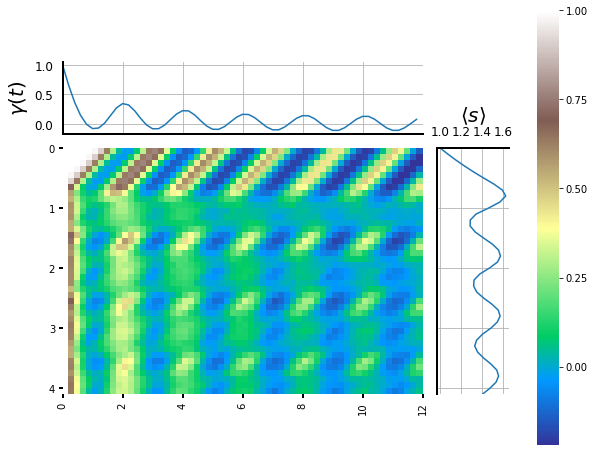

In [71]:
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1 import make_axes_locatable


fig,ax=plt.subplots(figsize=(10,8))

divider = make_axes_locatable(ax)


##increased pad from 0.1 to 0.2 so that tick labels don't overlap
xhax = divider.append_axes("top", size=1, pad=0.2, sharex=ax)
yhax = divider.append_axes("right", size=1, pad=0.2, sharey=ax)

##'normalizing' x and y values to be between 0 and 1:
#xn = (x-min(x))/(max(x)-min(x))
#yn = (y-min(y))/(max(y)-min(y))

##producinc the plots

#ax.scatter(xn, yn)
xhax.plot(tauarr7,np.array(corarr7))
yhax.plot(mnszarray7,range(len(mnszarray7)))
#yhax.hist(yn,)

##turning off duplicate ticks (if needed):
plt.setp(xhax.get_xticklabels(), visible=False)
plt.setp(yhax.get_yticklabels(), visible=False)

ax.set_aspect('equal')
ax.set_xlabel("lag",fontsize=20)
ax.set_ylabel(r"$t/\tau$",fontsize=20)
xhax.set_ylabel(r"$\gamma(t)$",fontsize=20)
yhax.set_xlabel(r"$\langle s \rangle$",fontsize=20)


sns.heatmap(np.array(corarrmat7),ax=ax,cmap="terrain",annot=False)

xhax.grid()
xhax.tick_params(axis='x', labelsize=12)
xhax.tick_params(axis='y', labelsize=12)
for axis in ['bottom','left']:
    xhax.spines[axis].set_linewidth(2)
    xhax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    xhax.spines[axis].set_linewidth(0)
    xhax.tick_params(axis='both', width=0,length=6)
    
yhax.grid()
yhax.tick_params(axis='x', labelsize=12)
yhax.tick_params(axis='y', labelsize=12)
for axis in ['top','left']:
    yhax.spines[axis].set_linewidth(2)
    yhax.tick_params(axis='both', width=2,length=6)
for axis in ['bottom','right']:
    yhax.spines[axis].set_linewidth(0)
    yhax.tick_params(axis='both', width=0,length=6)
taqui=np.arange(0,70,step=10)
ax.set_xticks(np.array(taqui))

taqui=np.arange(1,1.8,step=0.2)
yhax.set_xticks(np.array(taqui))

taqui=np.arange(0,50,step=10)
ax.set_yticks(np.array(taqui))
ax.tick_params(axis='both', width=2,length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    
yhax.xaxis.tick_top()
yhax.xaxis.set_label_position('top') 
#ax.tick_params(labelbottom=False,labelleft=False,)
#ax.setp(ax.get_xticklabels(), visible=False)
#
#ax.set_xticks(np.array(taqui))
#taqui=np.arange(0,20,step=1)
#ax.set_yticks(np.array(taqui))
plt.savefig('./heatmap1.eps',bbox_inches='tight',dpi=600)
plt.savefig('./heatmap1.svg',bbox_inches='tight',dpi=600)